# EDA

This notebook will go through the EDA, preprocessing, modelling, conclusions and recommendations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy # for Lemmatizing
import re # for regex
import os 

from sklearn.utils import resample # for downsampling to create more balanced classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('../data/outputs/Final_DataFrame_with_ylabels.csv',index_col=0)

In [3]:
df.head()

,title,score,subreddit,id,url,num_comments,comment,target
0,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Helps when the other side is pure fascism.,0
1,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,We know the alternative. \n\nThere’s no compar...,1
2,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,"For real, I am just terrified of the Republic...",0
3,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Biden sure wasn't my favourite in the primarie...,0
4,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,>President Joe Biden currently has a higher jo...,0


In [4]:
df = df.reset_index(drop=True)# resetting the index as I concatenated multiple webscraping and the index is not in order anymore.

We can first examine whether the topic of the subreddit has an effect on the number of offensive comments

In [5]:
df['subreddit'].unique()

array(['politics', 'science', 'Art', 'Music', 'funny', 'news', 'movies',
       'singapore', 'todayilearned', 'nottheonion', 'gaming', 'AskReddit',
       'aww', 'Showerthoughts', 'sports', 'food', 'worldnews', 'pics',
       'PublicFreakout', 'antiwork', 'SubredditDrama', 'facepalm',
       'entitledparents'], dtype=object)

In [6]:
counts = df.groupby(['subreddit','target']).count()['title'].reset_index()
counts

,subreddit,target,title
0,Art,0,181
1,Art,1,13
2,AskReddit,0,752
3,AskReddit,1,88
4,Music,0,259
5,Music,1,9
6,PublicFreakout,0,1367
7,PublicFreakout,1,466
8,Showerthoughts,0,263
9,Showerthoughts,1,26


## Number of Offensive and Non-offensive Comments per Subreddit

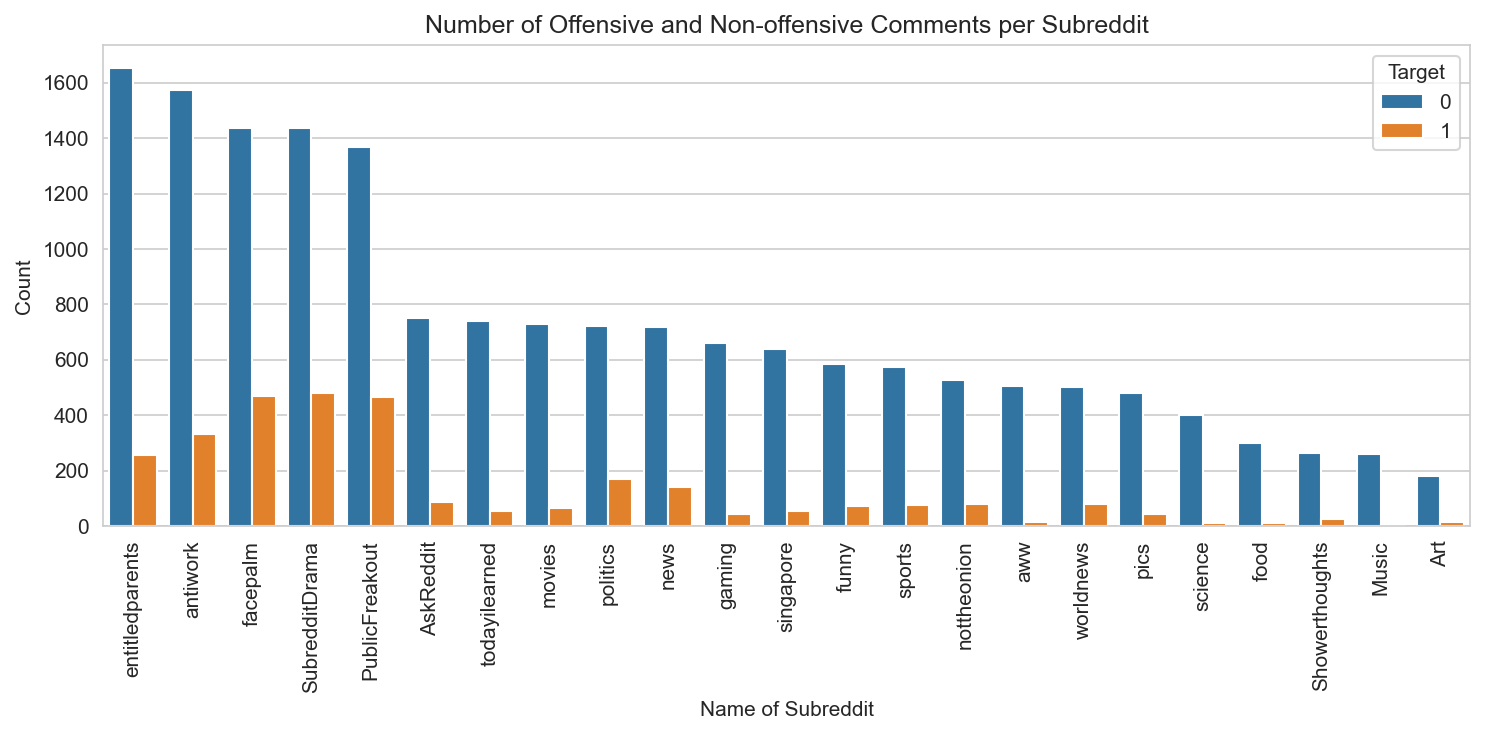

In [7]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,5),dpi=150)
sns.barplot(x='subreddit', y='title', hue='target', data=counts.sort_values(by='title',ascending=False),)
plt.xticks(rotation=90)
plt.title('Number of Offensive and Non-offensive Comments per Subreddit')
plt.ylabel('Count')
plt.xlabel('Name of Subreddit')
plt.legend(title = 'Target',loc='upper right')
plt.tight_layout();

From the plot above, we can see that topics do make a difference in whether there are more offensive comments as subreddits with similar number of comments scraped have visible differences in the number of offensive comments scraped. 

For example politics and movies. The ratio of offensive and non-offensive comments vary visibly. This is to be expected, as politics is usually a topic which people disagree on far more than compared to movies.

The plot is still a little hard to read, I will now get the percentage values of offensive comments in each subreddit to confirm that the topic plays a part in the number of offensive comments.

In [8]:
counts.groupby('subreddit').sum()['title'].values

array([ 194,  840,  268, 1833,  289, 1916, 1906,  517, 1907, 1907,  312,
        659,  704,  795,  857,  607,  522,  893,  413,  694,  651,  796,
        582])

Getting the total number of comments for each subreddit.

In [9]:
counts

,subreddit,target,title
0,Art,0,181
1,Art,1,13
2,AskReddit,0,752
3,AskReddit,1,88
4,Music,0,259
5,Music,1,9
6,PublicFreakout,0,1367
7,PublicFreakout,1,466
8,Showerthoughts,0,263
9,Showerthoughts,1,26


In [10]:
counts['title'][1::2]

1      13
3      88
5       9
7     466
9      26
11    479
13    331
15     13
17    255
19    469
21     12
23     74
25     44
27     65
29    140
31     79
33     42
35    170
37     11
39     54
41     77
43     54
45     81
Name: title, dtype: int64

Getting the number of offensive comments for each subreddit.

In [11]:
percentage_1 = []
for i in range(len(counts['title'][1::2].values)):
    percentage_1.append(round((100*(counts['title'][1::2].values[i]/counts.groupby('subreddit').sum()['title'].values[i])),2))
percentage_1

[6.7,
 10.48,
 3.36,
 25.42,
 9.0,
 25.0,
 17.37,
 2.51,
 13.37,
 24.59,
 3.85,
 11.23,
 6.25,
 8.18,
 16.34,
 13.01,
 8.05,
 19.04,
 2.66,
 7.78,
 11.83,
 6.78,
 13.92]

I now have the percentage of offensive comments over the total number of comments per subreddit.

Now I can repeat the code to get the percentage of non-offensive comments.

In [12]:
percentage_0 = []
for i in range(len(counts['title'][::2].values)):
    percentage_0.append(round((100*(counts['title'][::2].values[i]/counts.groupby('subreddit').sum()['title'].values[i])),2))

In [13]:
percentages = []
for a, b in zip(percentage_0, percentage_1):
    percentages.append(a)
    percentages.append(b)

Combining the percentages for both labels.

In [14]:
counts['percentages'] = percentages
counts

,subreddit,target,title,percentages
0,Art,0,181,93.30
1,Art,1,13,6.70
2,AskReddit,0,752,89.52
3,AskReddit,1,88,10.48
4,Music,0,259,96.64
5,Music,1,9,3.36
6,PublicFreakout,0,1367,74.58
7,PublicFreakout,1,466,25.42
8,Showerthoughts,0,263,91.00
9,Showerthoughts,1,26,9.00


In [15]:
counts.sort_values(by='percentages').iloc[:23]

,subreddit,target,title,percentages
15,aww,1,13,2.51
37,science,1,11,2.66
5,Music,1,9,3.36
21,food,1,12,3.85
25,gaming,1,44,6.25
1,Art,1,13,6.70
43,todayilearned,1,54,6.78
39,singapore,1,54,7.78
33,pics,1,42,8.05
27,movies,1,65,8.18


Separating to only get the target labels of value 1 for plotting.

## Percentage of Offensive Comments per Subreddit

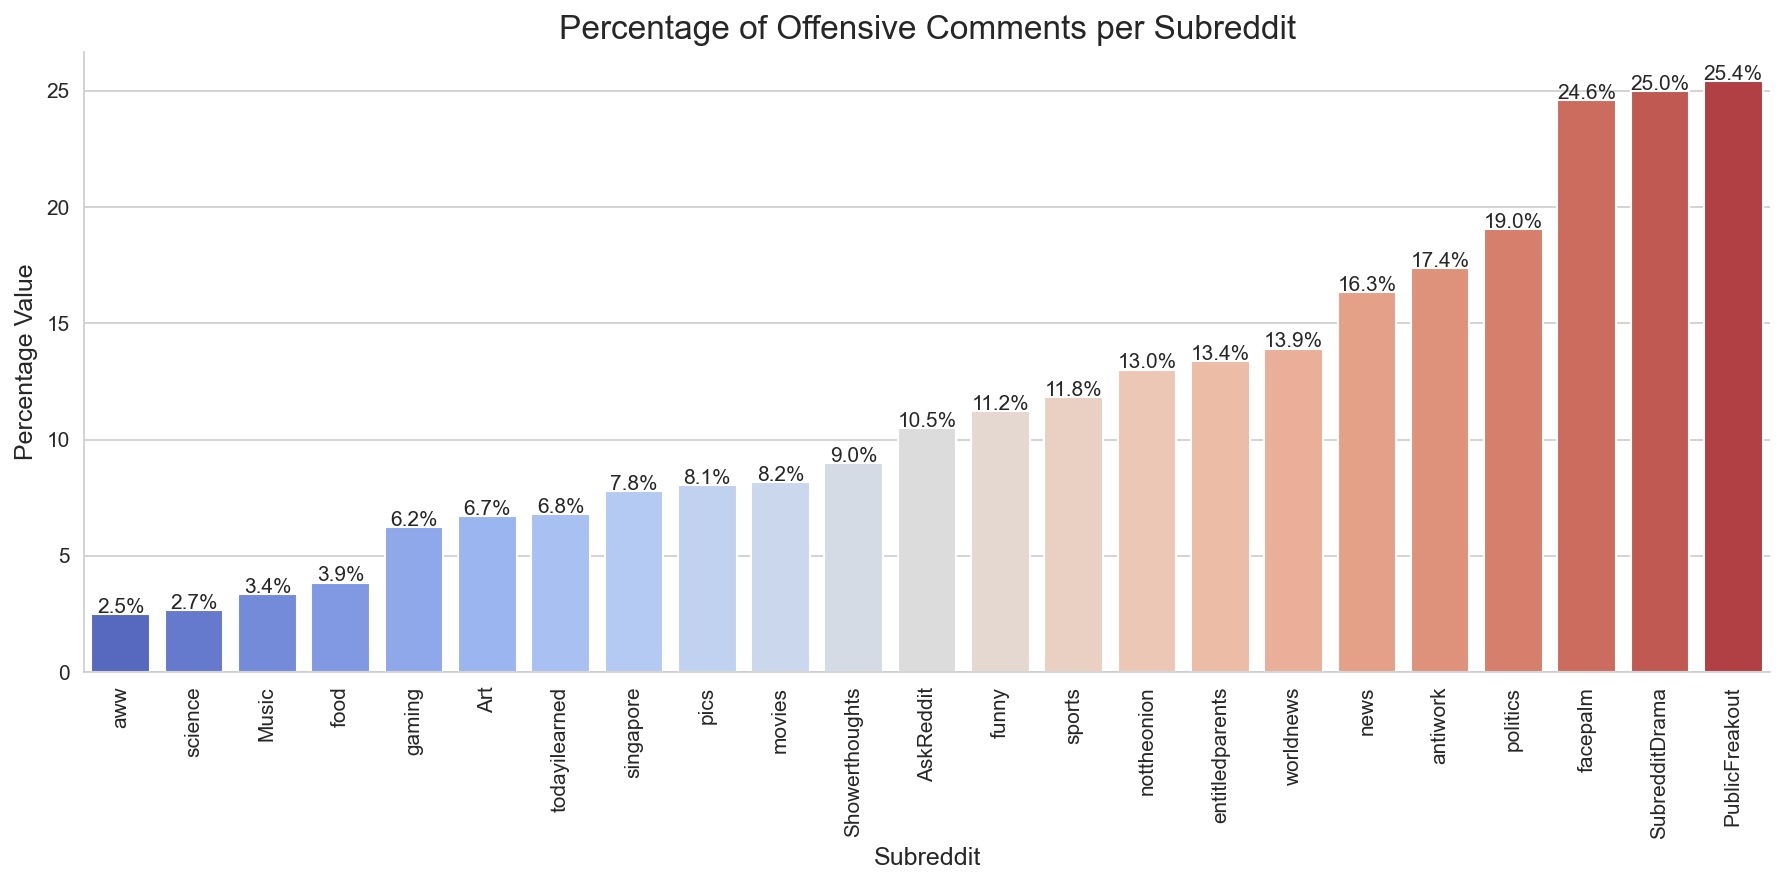

In [16]:
plt.figure(figsize=(12,6),dpi=150)

ax = sns.barplot(x='subreddit', y='percentages', data=counts.sort_values(by='percentages').iloc[:23], palette='coolwarm')
ax.set_title('Percentage of Offensive Comments per Subreddit', fontsize=16)
ax.set_ylabel('Percentage Value', fontsize=12)
ax.set_xlabel('Subreddit', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.yaxis.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(list(counts.sort_values(by='percentages').iloc[:23]['percentages'])[i]), (x, y), ha='center')# to input percentage values above each bar
    

As shown above, the topic definitely affects the number of offensive comments. This is to be expected as topics like politics generally elicit stronger opinions and consequently offensive comments. In the context of the problem statement, after initial rollout of the model, heavier moderation may be needed for particular topics if the university does intend on creating specific topics such as politics.

## Distribution of Number of Comments by Target Variable

Next let's look at whether the number of comments in a particular post affects the number of offensive comments.

In [17]:
df[['target','num_comments']].corr()['target']

target          1.000000
num_comments    0.104333
Name: target, dtype: float64

There is no correlation between the two.

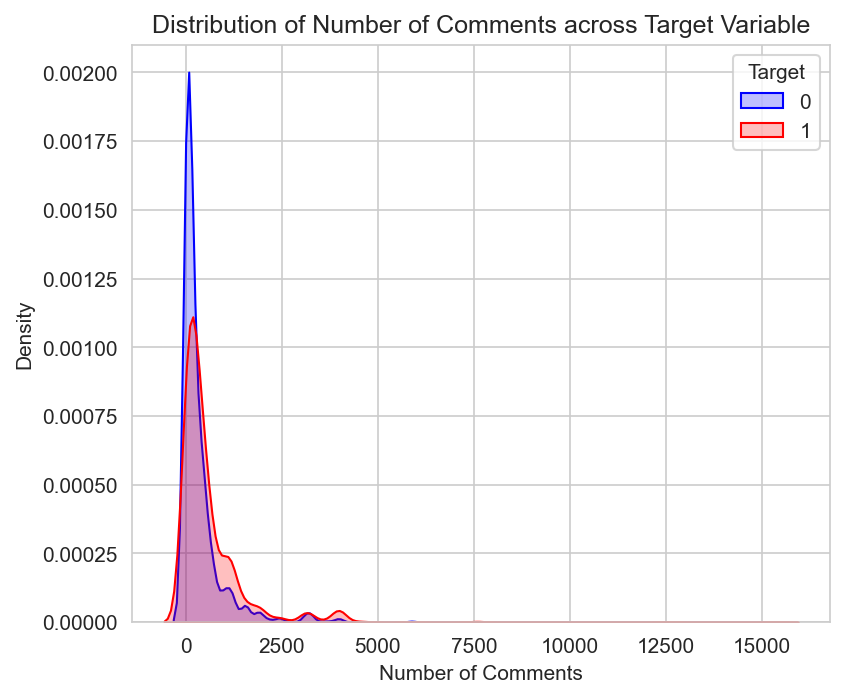

In [18]:
plt.figure(figsize=(6,5),dpi=150)

sns.kdeplot(df.loc[df['target'] == 0, 'num_comments'], label='0', color='blue', fill=True)
sns.kdeplot(df.loc[df['target'] == 1, 'num_comments'], label='1', color ='red', fill = True)
plt.title('Distribution of Number of Comments across Target Variable')
plt.xlabel('Number of Comments')
plt.ylabel('Density')
plt.legend(title='Target', loc='best')
plt.show();



From the plot above, I can see that there is indeed no correlation, a higher number of comments doesn't mean that there are more offensive comments and vice versa.

## Effect of Length and Word counts on Target Variable

Next I will see if the longer a comment is, whether there is a correlation with it being offensive or not. 

I will check based on number of words, and number of characters in a comment.

In [19]:
df['comment_length'] = df['comment'].apply(lambda x: len(x))

In [20]:
df['comment_word_count'] = df['comment'].apply(lambda x: len(x.split(' ')))

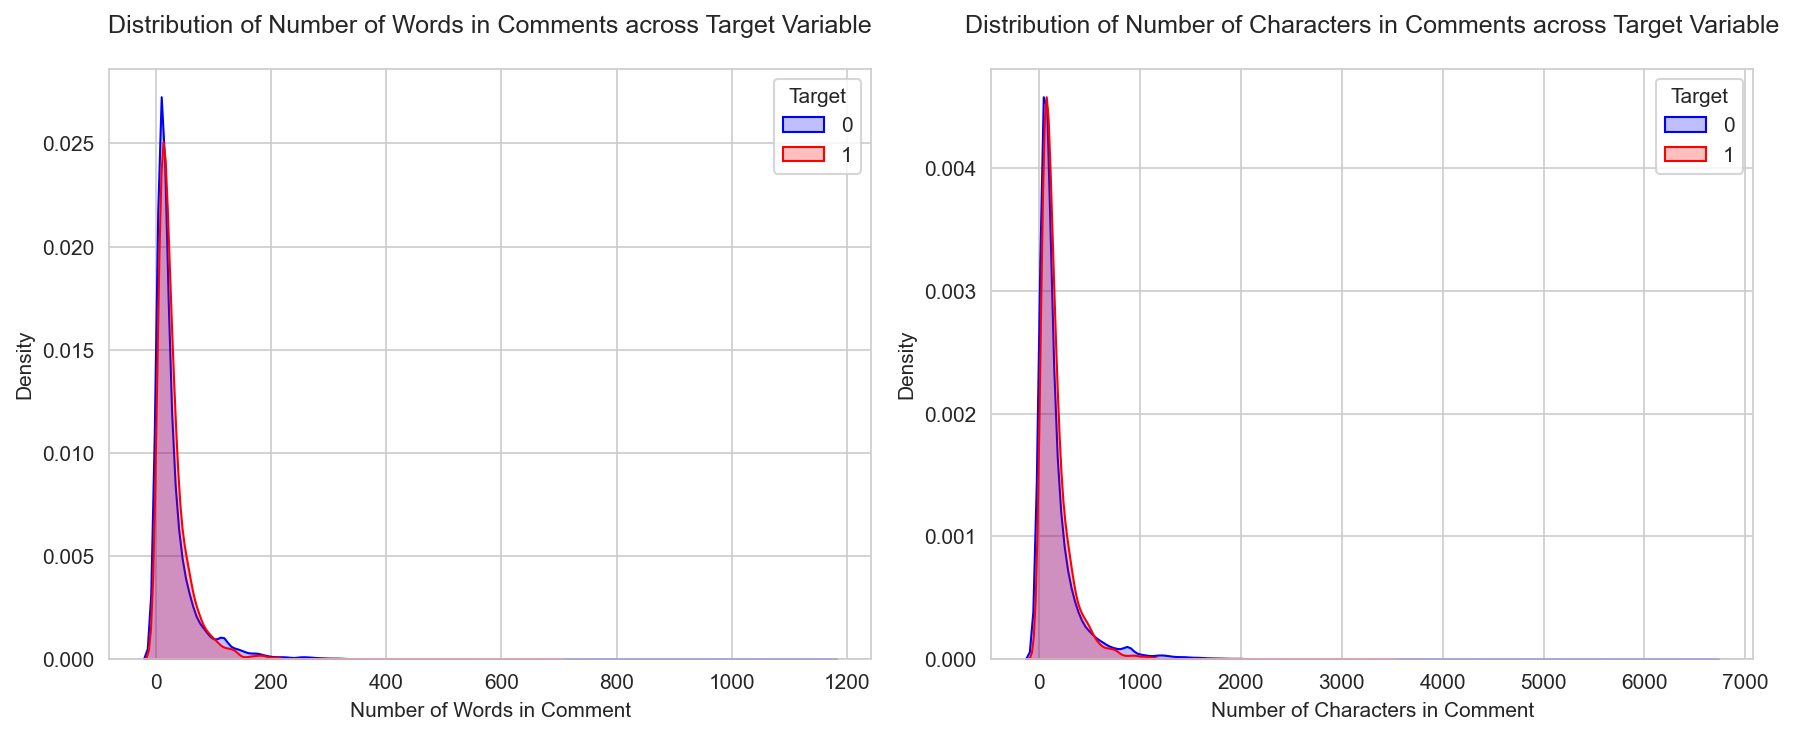

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), dpi=150)

sns.kdeplot(df.loc[df['target'] == 0, 'comment_word_count'], label='0', color='blue', fill=True, ax=ax1)
sns.kdeplot(df.loc[df['target'] == 1, 'comment_word_count'], label='1', color='red', fill=True, ax=ax1)
ax1.set_title('Distribution of Number of Words in Comments across Target Variable', y= 1.04)
ax1.set_xlabel('Number of Words in Comment')
ax1.set_ylabel('Density')
ax1.legend(title='Target')

sns.kdeplot(df.loc[df['target'] == 0, 'comment_length'], label='0', color='blue', fill=True, ax=ax2)
sns.kdeplot(df.loc[df['target'] == 1, 'comment_length'], label='1', color='red', fill=True, ax=ax2)
ax2.set_title('Distribution of Number of Characters in Comments across Target Variable', y = 1.04)
ax2.set_xlabel('Number of Characters in Comment')
ax2.set_ylabel('Density')
ax2.legend(title='Target')


plt.tight_layout();



From the above plots, I can see that the number of words and number of characters in a comment has no effect on the probability of the comment being offensive or not.

This is as the distributions of both target classes in both plots are overlapping, where if there was an effect, their distributions would not be overlapping. 

# Baseline Model Fitting

I will now move on to doing the train test split, transforming the data using CountVectorizer and passing it into my baseline model, before reviewing the results and doing more preprocessing such as lemmatizing, removing stop words, removing special characters, etc.

## Train-Test Split

In [22]:
df.head()

,title,score,subreddit,id,url,num_comments,comment,target,comment_length,comment_word_count
0,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Helps when the other side is pure fascism.,0,42,8
1,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,We know the alternative. \n\nThere’s no compar...,1,229,40
2,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,"For real, I am just terrified of the Republic...",0,178,32
3,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Biden sure wasn't my favourite in the primarie...,0,327,55
4,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,>President Joe Biden currently has a higher jo...,0,296,51


In [23]:
X = df['comment']
y = df['target']

Note that I am only using comments as the sole feature as we have established that comment_length, num_comments, comment_word_count has no effect on the target variable. I am also not using the other columns such as subreddit and title, because in the context of the problem statement, there will be no subreddit feature in the actual new test data. I will only have access to the comment itself, therefore the only feature I will be using in the model will be comments.

In [24]:
y.value_counts(normalize=True)

0    0.847872
1    0.152128
Name: target, dtype: float64

As my target class is imbalanced, I must use other metrics besides Accuracy for scoring and to stratify during train test split. I will use f1 score / recall to judge the model's performance.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

Doing my train-test split with stratify to balance the y labels equally between my y_train and y_test.

Also note that no scaling is required for the models I will be running.

## Baseline Model Performance 

In [26]:
cvec = CountVectorizer() # Instantiating CountVectorizer

In [27]:
cvec_X_train = cvec.fit_transform(X_train) #Fit_transform on training data
cvec_X_test = cvec.transform(X_test)# transform test data

In [28]:
nb_model = MultinomialNB() #Instantiating the model

In [29]:
nb_model.fit(cvec_X_train,y_train) # fitting the model

MultinomialNB()

In [30]:
nb_model.score(cvec_X_train,y_train)

0.9439217396722537

In [31]:
nb_model.score(cvec_X_test,y_test)

0.8968352853227012

Checking for overfitting or underfitting, the score for accuracy is pretty good across both training and test sets, however as previously mentioned, as my target classes are imbalanced, I should use other metrics such as f1_score and recall.

In [32]:
cross_val_score(nb_model,cvec_X_train,y_train,scoring = metrics.make_scorer(metrics.f1_score)).mean()#mean f1_score across 5 folds 

0.486028916043358

In [33]:
cross_val_score(nb_model,cvec_X_train,y_train,scoring = metrics.make_scorer(metrics.recall_score)).mean()# mean recall score across 5 folds

0.4205446042441919

In [34]:
y_pred = nb_model.predict(cvec_X_test) # making predictions using test set

In [35]:
baseline_model_scores = (metrics.classification_report(y_test,y_pred))
print(baseline_model_scores)# printing classification report

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3403
           1       0.79      0.43      0.56       610

    accuracy                           0.90      4013
   macro avg       0.85      0.71      0.75      4013
weighted avg       0.89      0.90      0.88      4013



The results from the above lines of code shows the average f1 and recall score across 5 folds on the training set and the classification report of the test set.

We can see that the test set's f1_score of 0.56 is actually better than the cross validated score of 0.48. This is promising as it means that there is no overfitting.

Although it is better, it still isn't particularly impressive with an f1 score of only 0.56. 

This will be the baseline score to compare against future models after improvements have been done to the dataset.

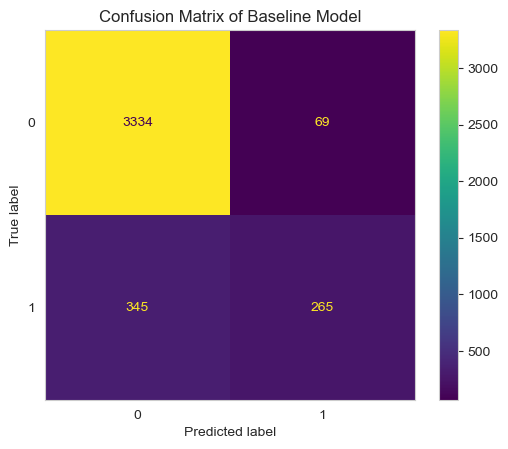

In [36]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title('Confusion Matrix of Baseline Model')
plt.grid(None)

From the confusion matrix of the baseline model, we can see that the model is not simply predicting everything as the majority class which is a good thing.

# Improving Model Performance

Having seen the results of the baseline model where none of the usual preprocessing steps for NLP were done, I will now do preprocessing to improve performance.

The following will be done:
1. Removing special characters
1. Removing stopwords
1. Lemmatizing
1. Tuning vectorizer parameters

Let's start with removing special characters.

## Removing Special Characters

Let's first remove all symbols from each comment such as !@#$%^&*().

In [37]:
test = 'test sentence !!@#$%^&*()__' # test sentence to see if the regex expression is working to remove symbols.
re.sub(r'[^a-zA-Z\d\s:]','',test)#regex expression to remove all symbols.

'test sentence '

In [38]:
df['comment'] = df['comment'].str.replace(r'[^a-zA-Z\d\s:]', '', regex=True)#applying the regex expression to my corpus.

Next I will remove all non-english characters

In [39]:
test = '拿枪射我退退退행복'
re.sub(r'[^\x00-\x7F]', '', test)#regex expression to remove all non-english characters

''

In [40]:
df['comment'] = df['comment'].str.replace(r'[^\x00-\x7F]', '', regex=True)#applying the regex expression to my corpus.

Next I will also remove all numbers from the corpus.

The reason for doing this is in the context of the problem statement that I am trying to identify offensive comments. Offensive comments are almost always said through words and not numbers. I have never heard of people being insulted through using numbers only. If there is, it is extremely rare.

As such, I will remove all numbers from the corpus to try and reduce the dimensionality.

In [41]:
test = 'numbers 1234567890'
re.sub(r'\d+', '', test)

'numbers '

In [42]:
df['comment'] = df['comment'].str.replace(r'\d+', '', regex=True)#applying the regex expression to my corpus.

Removing \n from the corpus

In [43]:
test = 'test sentence \n' # test sentence to see if the regex expression is working to remove symbols.
re.sub(r'[\n]','',test)#regex expression to remove all symbols.

'test sentence '

In [44]:
df['comment'] = df['comment'].str.replace(r'[\n]', '', regex=True)#applying the regex expression to my corpus.

I have now removed special characters which I think negatively affects model performance. Moving on to removing stop words.

## Removing Stop Words

In [45]:
cvec_df = pd.DataFrame(cvec.fit_transform(df['comment']).toarray(), columns=cvec.get_feature_names_out())
cvec_df

,aaaaand,aaaah,aaaand,aah,aardvark,aaron,aback,abaft,abandon,abandoned,...,zoos,zoosanctuary,zoowildlife,zorba,zscore,zucc,zuckerberg,zuse,zygote,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I have returned a DataFrame with my X count-vectorized in order to check what are the most frequently occuring words in the dataset and if they are all stopwords. If they are, I will know that I am on the right track by removing stopwords.

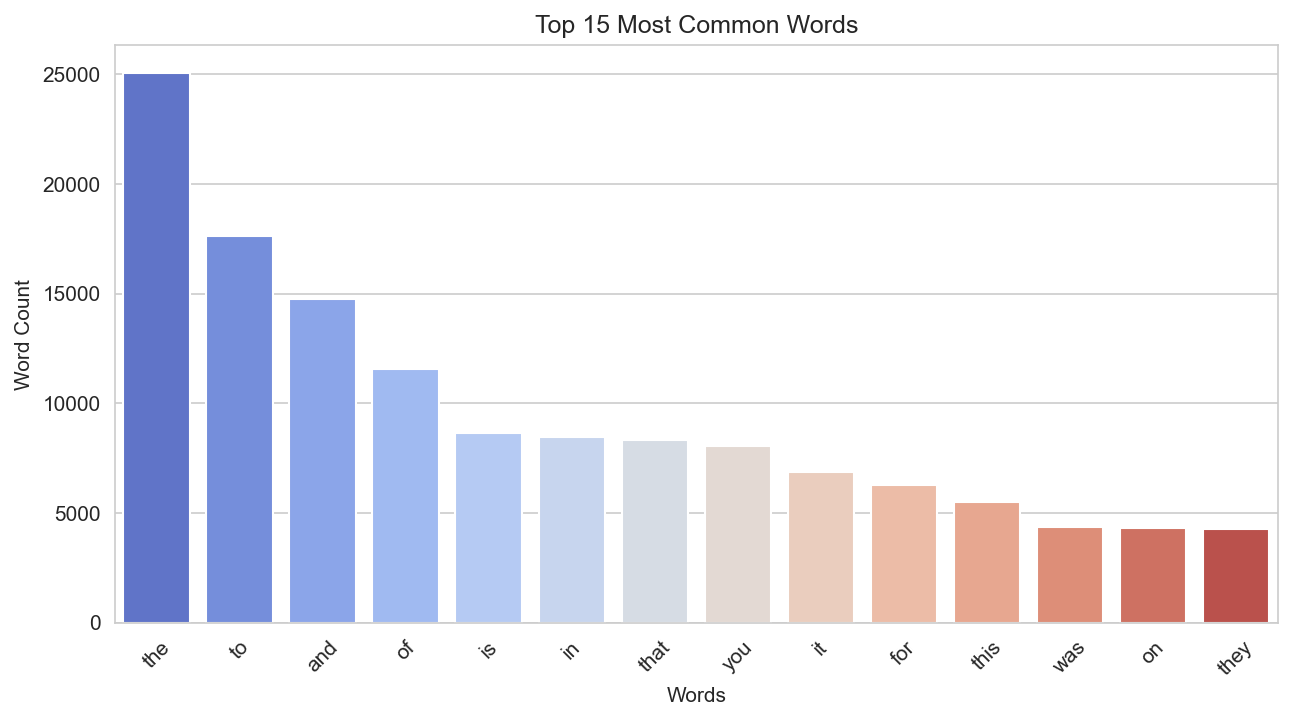

In [46]:
plt.figure(figsize=(10,5),dpi = 150)
sns.barplot(x=cvec_df.sum().sort_values(ascending=False)[0:14].index,y=cvec_df.sum().sort_values(ascending=False)[0:14].values,palette='coolwarm')
plt.title('Top 15 Most Common Words')
plt.xlabel('Words')
plt.xticks(rotation = 45)
plt.ylabel('Word Count');


From the plot above, we can see the most frequent words in the dataset / corpus are all stopwords. I will remove stopwords in the following models.

## Lemmatizing the Corpus

Now I will lemmatize my corpus to reduce the dimensionality and to also try and improve model performance.

In [47]:
nlp = spacy.load("en_core_web_sm") # loading spacy to use for lemmatization

def lemmatize(document): #function to lemmatize my documents
    doc = nlp(document)
    lemmatized_text = [word.lemma_ for word in doc]
    return " ".join(lemmatized_text)

In [48]:
lemmatize('I like to go cycling') 

'I like to go cycle'

Note the output changes the word cycling to cycle. Lemmatizing is working as intended.

Now to lemmatize my entire corpus. 

In [49]:
%%time

df['comment'] = df['comment'].apply(lemmatize)

CPU times: user 2min 24s, sys: 970 ms, total: 2min 25s
Wall time: 2min 26s


In [50]:
df

,title,score,subreddit,id,url,num_comments,comment,target,comment_length,comment_word_count
0,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,help when the other side be pure fascism,0,42,8
1,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,we know the alternative there s no comparison ...,1,229,40
2,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,for real I be just terrified of the Republic...,0,178,32
3,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Biden sure be not my favourite in the primary ...,0,327,55
4,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,President Joe Biden currently have a high job ...,0,296,51
...,...,...,...,...,...,...,...,...,...,...
20057,Mom wants stepdad to adopt me so she can inher...,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comme...,392,do not sound line you have anything in inherit...,0,107,17
20058,Mom wants stepdad to adopt me so she can inher...,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comme...,392,why be she so concerned about you die do you h...,0,134,25
20059,Mom wants stepdad to adopt me so she can inher...,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comme...,392,be it even possible for your stepdad to adopt ...,0,130,25
20060,Mom wants stepdad to adopt me so she can inher...,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comme...,392,burn I with all my stuff its mine my cousin ac...,0,75,13


DataFrame with lemmatized text, special characters removed. I will now fit the next set of models with this improved dataset and to remove stopwords during vectorizing.

# Second Round of Model Fitting 

In [51]:
X = df['comment']
y = df['target']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [53]:
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

Building my pipeline to fit the model.

Note the parameter stop_words in CountVectorizer, this is to remove all stop_words as previously discussed.

In [54]:
cvec_pipe_params = {
    'cvec__max_features': [5000, 10000, 15000, 20000], # start with CountVectorizer() class' object cvec__CountVectorizer()'s hyperparameter
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)] # test unigram only (1,1) and unigram+bigram (1,2)
} # standard param dict definition for GridSearch CV

Creating my parameters dictionary for the Gridsearch to try. 

1. cvec__max_features is the number of most frequent words that the vectorizer will include in the matrix. This is as having too many unique words may be too complex and take up too much space.
1. cvec__min_df is the minimum number the word / token must appear before it is used. As if the word only appears in one document, it is an outlier and may not matter.
1. cvec__max_df is the opposite, where if a word appears in all documents, that means it may not be useful in predicting whether a comment is offensive or not
1. cvec__ngram_range is to try unigram or unigram and bigram, as words have an order to them and taken together may be better at improving model performance.

In [55]:
# Instantiate GridSearchCV.

cvec_gs = GridSearchCV(cvec_pipe,
                  param_grid=cvec_pipe_params, 
                  cv=5,
                 verbose=1)

In [56]:
%%time

cvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 53.7 s, sys: 889 ms, total: 54.6 s
Wall time: 55.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000, 20000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [57]:
cvec_gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

Here are the best parameters found by the gridsearch.

In [58]:
metrics.recall_score(y_train,cvec_gs.predict(X_train))# recall score for training set

0.8390663390663391

In [59]:
y_pred = cvec_gs.predict(X_test)

In [60]:
improved_model_score = (metrics.classification_report(y_test,y_pred)) 
print(improved_model_score)# printing classification report

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3403
           1       0.73      0.64      0.68       610

    accuracy                           0.91      4013
   macro avg       0.83      0.80      0.81      4013
weighted avg       0.90      0.91      0.91      4013



The improved model does perform better compared to the baseline model based on the f1 score for the offensive target label. The f1-score improved from 0.56 to 0.68, and more importantly the recall score for offensive comments improved from 0.43 to 0.64. This means that the lemmatizing, removing stopwords, removing special characters, and tuning the vectorizer parameters did help.

However, the model has now become overfit as shown in the recall_score on the training set which is 0.83. I will need to try and make the model less overfit.

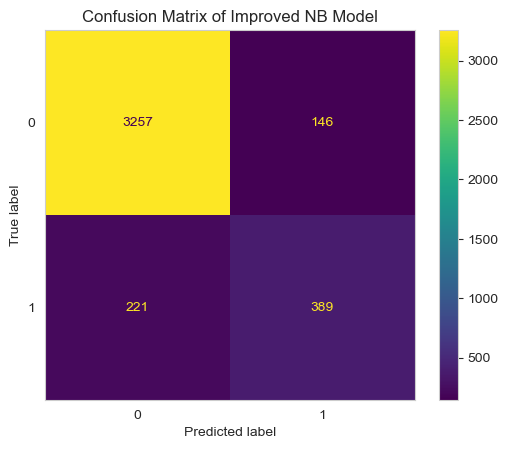

In [61]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title('Confusion Matrix of Improved NB Model')
plt.grid(None)

Confusion Matrix for this model. Notice that there are more correct predictions for offensive comments in this model after improvements were made.

# Downsampling to Improve Model Performance

I will now try to further improve model performance and reduce overfitting by downsampling. Recall that the target classes are heavily imbalanced even after I scraped data from subreddits which were likely to have more offensive comments.

In [62]:
df['target'].value_counts(normalize=True)

0    0.847872
1    0.152128
Name: target, dtype: float64

As shown above, the target classes are imbalanced, I will downsample to have a 50-50 split and pass this dataset to the model to see if it improves performance.

In [63]:
# Separating the majority and minority classes
majority_class = df[df['target'] == 0]
minority_class = df[df['target'] == 1]

In [64]:
# Downsampling the majority class
majority_downsampled = resample(majority_class,
                                replace=False, # Sample without replacement so that there is no chance to take the same row value.
                                n_samples=len(minority_class), # Match minority class size so that the target classes are 50:50
                                random_state=42) 


In [65]:
# Combine the downsampled majority class with the minority class
downsampled = pd.concat([majority_downsampled, minority_class])

In [66]:
# Shuffle the combined dataset to avoid bias
downsampled = downsampled.sample(frac=1, random_state=42)

In [67]:
downsampled

,title,score,subreddit,id,url,num_comments,comment,target,comment_length,comment_word_count
15043,Boston Marathon runner takes a shit in OP's ya...,3073,SubredditDrama,12psgfk,https://www.reddit.com/r/SubredditDrama/commen...,1126,I get that running shit happen and happen pret...,1,314,59
12163,Parking Spot Karen Loses It When Someone Parks...,71,PublicFreakout,12xs2uc,https://v.redd.it/al4ktc21nvva1,36,an entire subdivision of the same shitty house...,1,90,16
60,"Trump team texts are ""stronger evidence"" of Ge...",4781,politics,12vhq9y,https://www.newsweek.com/trump-team-texts-are-...,114,hey make sure you do not forget Lindsey Graham...,0,59,11
1826,What going on here,10312,funny,12vauh4,https://v.redd.it/cxicu90f5iva1,683,Establish Dominance with the old hump and wack,0,47,8
14172,When are the stupid questions during interview...,22,antiwork,12y0kvi,https://www.reddit.com/r/antiwork/comments/12y...,10,they ll only get bad due to more stupid people...,1,81,14
...,...,...,...,...,...,...,...,...,...,...
6951,"If God is inherently good, why did he create a...",38,AskReddit,12w12bv,https://www.reddit.com/r/AskReddit/comments/12...,232,People be scared of die so they make shit up,1,47,10
15504,Joe Rogan user is having a rational conversati...,770,SubredditDrama,12kezkq,https://old.reddit.com/r/JoeRogan/comments/12i...,1012,its interesting how many caveman still walk ar...,1,222,39
15666,OP claims to have taken weeks hand painting 40...,791,SubredditDrama,12j2jgk,https://www.reddit.com/r/SubredditDrama/commen...,96,okay disregard the fact that its mostly fake h...,1,146,24
16310,Stop recording me whilst I unlawfully arrest you,60863,facepalm,12xhcjk,https://v.redd.it/tel86mqqcuva1,3984,now imagine this scenario play out where this ...,1,248,40


In [68]:
downsampled['target'].value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

Here is my dataset with balanced classes. I will now try to fit this dataset to the same model.

## Model Fitting with Downsampled Dataset

In [69]:
X = downsampled['comment']
y = downsampled['target']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

I will now run the downsampled data through the same gridsearch pipeline I previously created with the same parameters.

In [71]:
%%time

cvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 14.8 s, sys: 123 ms, total: 14.9 s
Wall time: 15 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000, 20000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [72]:
cvec_gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

Here are the best parameters found by the gridsearch. It has chosen different best parameters compared to the dataset without downsampling. It has chosen 5000 max features instead of 10000 which is to be expected since there are much less rows than the previous dataset meaning there are less unique words.

For the ngram_range, the best parameter is (1,2) which means that unigram and bigram was chosen, instead of the previous only unigram being chosen.

In [73]:
metrics.recall_score(y_train,cvec_gs.predict(X_train))#recall score for training set.

0.9692874692874693

In [74]:
y_pred = cvec_gs.predict(X_test)

In [75]:
downsampled_model_score = metrics.classification_report(y_test,y_pred)
print(downsampled_model_score)
print('Downsampled MultinomialNB model score\n')
print(improved_model_score)
print('MultinomialNB model score')

              precision    recall  f1-score   support

           0       0.88      0.59      0.71       611
           1       0.69      0.92      0.79       610

    accuracy                           0.75      1221
   macro avg       0.79      0.75      0.75      1221
weighted avg       0.79      0.75      0.75      1221

Downsampled MultinomialNB model score

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3403
           1       0.73      0.64      0.68       610

    accuracy                           0.91      4013
   macro avg       0.83      0.80      0.81      4013
weighted avg       0.90      0.91      0.91      4013

MultinomialNB model score


Here are the classification reports for the downsampled model (on the top), and the model without downsampling (on the bottom).

As expected, the f1-score for my offensive y labels have improved significantly from an f1 score of 0.68 to 0.79. In particular, the recall score has improved from 0.64 to 0.92, which is a great improvement. Also notice that the model is significantly less overfit compared to the previous model.

However, the f1 and recall score for the non-offensive y labels have dropped from 0.95 to 0.71 and 0.96 to 0.59 for f1-score and recall respectively which is due to the fact that there is less of these rows in the dataset.

To decide which model to choose, in the context of the problem statement, it would depend on what the school wants to identify. Whether identifying as many offensive comments as possible regardless of the number of false positives is their priority or if they wanted to not be too strict on what was restricted and to let some offensive comments through to reduce false positives.

In this case, I will prioritise a higher recall at the expense of precision for my offensive comments as this is more importanat to the school. Therefore, between these 2 models. The model with downsampled dataset is better.

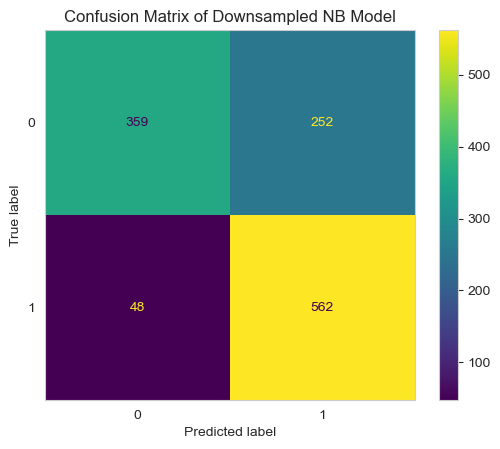

In [76]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title('Confusion Matrix of Downsampled NB Model')
plt.grid(None)

Notice the high number of True Positives the model has predicted.

# Random Forest Model

I will now try to fit the data to a random forest model to see if it improves performance.

In [77]:
rf_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english',max_df=0.9,max_features=5000,min_df=2,ngram_range=(1,2))), # tuple for transformer object, class
    ('rf', RandomForestClassifier()) # tuple for estimator object, class
])

Building a new pipeline with random forest as the estimator this time instead of MultinomialNB. 

Notice that I have instantiated the CountVectorizer with the best parameters found in the previous gridsearch and not including in the params dictionary this time to reduce fitting time and complexity.

In [78]:
rf_cvec_pipe_params = {
    'rf__n_estimators': [100,200,300], # no. of trees to make
    'rf__max_depth': [3,4,5], # how many layers can the trees grow
    'rf__min_samples_split': [10,50,100] # how many samples needs to be in the node before splitting
} # standard param dict definition for GridSearch CV

In [79]:
# Instantiate GridSearchCV.

rf_cvec_gs = GridSearchCV(rf_cvec_pipe,
                  param_grid=rf_cvec_pipe_params, 
                  cv=5,
                 verbose=1)

In [80]:
%%time

rf_cvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 38.9 s, sys: 320 ms, total: 39.2 s
Wall time: 39.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.9,
                                                        max_features=5000,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [3, 4, 5],
                         'rf__min_samples_split': [10, 50, 100],
                         'rf__n_estimators': [100, 200, 300]},
             verbose=1)

The X_train and y_train is the downsampled ones as it was the most recently assigned to these variables, which is what I want to use.

In [81]:
metrics.recall_score(y_train,rf_cvec_gs.predict(X_train))

0.7375102375102375

In [82]:
y_pred = rf_cvec_gs.predict(X_test)

In [83]:
downsampled_rf_model_score = metrics.classification_report(y_test,y_pred)
print(downsampled_rf_model_score)
print('Downsampled Random Forest Model Score\n')
print(downsampled_model_score)
print('Downsampled Multinomial NB Model Score\n')
print(improved_model_score)
print('MultinomialNB Model Score')

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       611
           1       0.93      0.73      0.82       610

    accuracy                           0.84      1221
   macro avg       0.85      0.84      0.83      1221
weighted avg       0.85      0.84      0.83      1221

Downsampled Random Forest Model Score

              precision    recall  f1-score   support

           0       0.88      0.59      0.71       611
           1       0.69      0.92      0.79       610

    accuracy                           0.75      1221
   macro avg       0.79      0.75      0.75      1221
weighted avg       0.79      0.75      0.75      1221

Downsampled Multinomial NB Model Score

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3403
           1       0.73      0.64      0.68       610

    accuracy                           0.91      4013
   macro avg       0.83      0.80      0.81      

From the above classification, I can see that the random forest produces the most balanced results between all the models I've currently tested, with an f1-score of 0.85 and 0.81 for 0 and 1 target class respectively. It also does not have the problem of overfitting.

Again, in the context of the problem statement, as the priority is to catch offensive comments, the current best model is still the Downsampled Multinomial NB model as the recall for the target class 1 is the highest out of all the models.

# TF-IDF Vectorizer Pipeline Models

## Fitting Original Dataset without Downsampling

Next I will try to use TF-IDF vectorizer instead of CountVectorizer to see if it improves performance. I will test the model on both the original dataset and the dataset with downsampling. I will start with the original dataset.

In [84]:
tvec_pipe = Pipeline([
    ('tvec',TfidfVectorizer(stop_words = 'english')),
    ('nb',MultinomialNB())
])

Instantiating a new pipeline with TF-IDF vectorizer instead of count vectorizer

In [85]:
tvec_pipe_params = {
    'tvec__max_features': [5000, 10000, 15000, 20000], 
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)] # test unigram only (1,1) and unigram+bigram (1,2)
} # standard param dict definition for GridSearch CV

Creating my new gridsearch parameters dictionary

In [86]:
# Instantiate GridSearchCV.
tvec_gs = GridSearchCV(tvec_pipe,
                  param_grid=tvec_pipe_params, 
                  cv=5,
                 verbose=1)

In [87]:
X = df['comment']
y = df['target']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

Setting X and y to be back to the original dataset without downsampling.

In [89]:
tvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000, 10000, 15000, 20000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [90]:
tvec_gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [91]:
metrics.recall_score(y_train,tvec_gs.predict(X_train))

0.300982800982801

In [92]:
y_pred = tvec_gs.predict(X_test)

In [93]:
tvec_nb_score=(metrics.classification_report(y_test,y_pred))
print(tvec_nb_score)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3403
           1       0.99      0.24      0.39       610

    accuracy                           0.88      4013
   macro avg       0.93      0.62      0.66      4013
weighted avg       0.90      0.88      0.85      4013



This model with TF-IDF vectorizer and the original dataset, performs terribly at identifying offensive comments. This model will definitely not be selected as the final model.

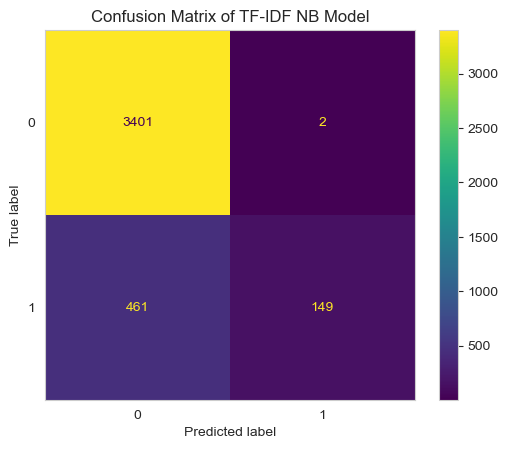

In [94]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title('Confusion Matrix of TF-IDF NB Model')
plt.grid(None)

Note the number of False Negatives that the model predicted. This is not a good model in terms of the problem statement.

## Downsampling NB Model

In [95]:
X = downsampled['comment']
y = downsampled['target']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

Now X and y is downsampled

In [97]:
tvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000, 10000, 15000, 20000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [98]:
tvec_gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [99]:
metrics.recall_score(y_train,tvec_gs.predict(X_train))

0.9631449631449631

In [100]:
y_pred = tvec_gs.predict(X_test)

In [101]:
downsampled_tvec_nb_score=(metrics.classification_report(y_test,y_pred))
print(downsampled_tvec_nb_score)

              precision    recall  f1-score   support

           0       0.84      0.65      0.73       611
           1       0.71      0.88      0.79       610

    accuracy                           0.76      1221
   macro avg       0.78      0.76      0.76      1221
weighted avg       0.78      0.76      0.76      1221



The performance on the downsampled data set is much better at predicting offensive comments regardless of the vectorizer used as can be seen in the results above.

## Downsampled Random Forest Model

The last model I will try using TF-IDF vectorizer is a random forest model on the downsampled dataset. After this I will compare all the models and select the best model to solve the problem statement.

In [102]:
rf_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english',max_df=0.9,max_features=5000,min_df=3,ngram_range=(1,2))), # tuple for transformer object, class
    ('rf', RandomForestClassifier()) # tuple for estimator object, class
])

Building a new pipeline with random forest as the estimator this time instead of MultinomialNB.

Again notice that I have instantiated the TF-IDF vectorizer with the best parameters found in the previous model.

In [103]:
rf_tvec_pipe_params = {
    'rf__n_estimators': [100,200,300], # no. of trees to make
    'rf__max_depth': [3,4,5], # how many layers can the trees grow
    'rf__min_samples_split': [10,50,100], # how many samples needs to be in the node before splitting
} # standard param dict definition for GridSearch CV

In [104]:
# Instantiate GridSearchCV.
rf_tvec_gs = GridSearchCV(rf_tvec_pipe,
                  param_grid=rf_tvec_pipe_params, 
                  cv=5,
                 verbose=1)

In [105]:
rf_tvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=5000,
                                                        min_df=3,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [3, 4, 5],
                         'rf__min_samples_split': [10, 50, 100],
                         'rf__n_estimators': [100, 200, 300]},
             verbose=1)

In [106]:
metrics.recall_score(y_train,rf_tvec_gs.predict(X_train))

0.7473382473382474

In [107]:
y_pred = rf_tvec_gs.predict(X_test)

In [108]:
downsampled_tvec_rf_score=(metrics.classification_report(y_test,y_pred))
print(downsampled_tvec_rf_score)

              precision    recall  f1-score   support

           0       0.78      0.94      0.86       611
           1       0.93      0.74      0.82       610

    accuracy                           0.84      1221
   macro avg       0.86      0.84      0.84      1221
weighted avg       0.86      0.84      0.84      1221



With all the model's fitted, I will now compare it all and choose the final model.

# Final Model Selection

<table><thead><tr><th>No.</th><th>Model</th><th>Target</th><th>Precision</th><th>Recall</th><th>f1-score</th><th>support</th></tr></thead><tbody><tr><td rowspan="2">1</td><td rowspan="2">Improved Model<br>(CountVectorizer - MultinomialNB)</td><td>0</td><td>0.94</td><td>0.96</td><td>0.95</td><td>3403</td></tr><tr><td>1</td><td>0.73</td><td>0.64</td><td>0.68</td><td>610</td></tr><tr><td rowspan="2">2</td><td rowspan="2">Downsampled Model<br>(CountVectorizer - MultinomialNB)</td><td>0</td><td>0.88</td><td>0.59</td><td>0.71</td><td>611</td></tr><tr><td>1</td><td>0.69</td><td>0.92</td><td>0.79</td><td>610</td></tr><tr><td rowspan="2">3</td><td rowspan="2">Downsampled Random Forest Model<br>(CountVectorizer - Random Forest)</td><td>0</td><td>0.78</td><td>0.94</td><td>0.85</td><td>611</td></tr><tr><td>1</td><td>0.93</td><td>0.73</td><td>0.82</td><td>610</td></tr><tr><td rowspan="2">4</td><td rowspan="2">Improved Model<br>(TF-IDF Vectorizer - MultinomialNB)</td><td>0</td><td>0.88</td><td>1.00</td><td>0.94</td><td>3403</td></tr><tr><td>1</td><td>0.99</td><td>0.24</td><td>0.39</td><td>610</td></tr><tr><td rowspan="2">5</td><td rowspan="2">Downsampled Model<br>(TF-IDF Vectorizer - MultinomialNB)</td><td>0</td><td>0.84</td><td>0.65</td><td>0.73</td><td>611</td></tr><tr><td>1</td><td>0.71</td><td>0.88</td><td>0.79</td><td>610</td></tr><tr><td rowspan="2">6</td><td rowspan="2">Downsampled Random Forest Model<br>(TF-IDF Vectorizer - Random Forest)</td><td>0</td><td>0.78</td><td>0.94</td><td>0.86</td><td>611</td></tr><tr><td>1</td><td>0.93</td><td>0.74</td><td>0.82</td><td>610</td></tr></tbody></table>

An overview of all the models and its results.

### Conclusions & Recommendations

To conclude, in the context of the problem statement, the best model would be model number 2, the Downsampled CountVectorized Multinomial NB model.

This is as the model had the highest recall for the target label 1 or offensive commments, which is what the problem statement seeks to achieve, to identify as many offensive comments as possible. In this regard, the project has succeeded as it produced a model which is able to correctly identify 92% of offensive comments.

The school can now run all student comments through the model to flag out offensive comments before they get posted to the message boards.

Recommendations for the school to further improve on this model are as follows:
1. Once the new message board has been rolled out, they can create topics similar to the concept of subreddits. This will give an additional datapoint for future models to learn from, as can be seen from my EDA that the subreddit the comment was scraped for had an effect on the probability of the comment being offensive. The school can therefore take note of certain topics which are more likely to produce offensive comments.
1. To include other languages as part of the model, as Singapore is a multiracial country, the students will submit comments in other languages as well. Future models will therefore need to be trained in the local languages to identify offensive comments.